In [1]:
%load_ext autoreload
%autoreload 2

# Hyperdt install

In [2]:
# %%bash
# which python
# cd ~
# git clone https://github.com/qc2321/hyperDT # Quentin's updated version of hyperDT
# cd hyperDT
# pip install -e .

In [74]:
%%bash
pip install geomstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 101.9 MB/s eta 0:00:00 0:00:01



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


# HyperDT benchmark - Gaussian mixtures

In [71]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import embedders

from hyperdt.tree import HyperbolicDecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


1.0
0.995


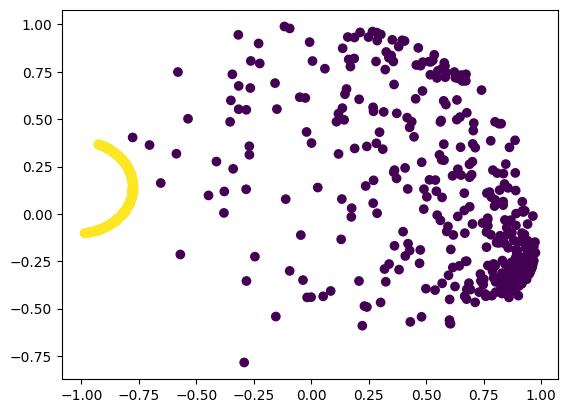

In [70]:
# Basic structure: let's do H2

signature = [(-1, 2)]
pm = embedders.manifolds.ProductManifold(signature=signature)

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm, seed=0, cov_scale_means=1.0, cov_scale_points=1.0)
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# hyperDT
hdt = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=1)
hdt.fit(X_train, y_train)
print(hdt.score(X_test, y_test))

# sklearn
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

# Also let's visualize the points
X_poincare = embedders.visualization.hyperboloid_to_poincare(X)
plt.scatter(X_poincare[:, 0], X_poincare[:, 1], c=y)

In [166]:
from tqdm.notebook import tqdm
from hyperdt.product_space_DT import ProductSpaceDT
from sklearn.metrics import accuracy_score, f1_score

results = []

CURVATURES = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
DIM = 2
N_SAMPLES = 200

my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
for i, K in enumerate(CURVATURES):
    for seed in range(N_SAMPLES):
        # Ensure unique seed per trial
        seed = seed + N_SAMPLES * i
        pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)])

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm, seed=seed, num_classes=10, cov_scale_means=1.0, cov_scale_points=1.0
        )
        X = X.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Evaluate sklearn
        dt = DecisionTreeClassifier(max_depth=3)
        dt.fit(X_train, y_train)
        # dt_acc = accuracy_score(dt.predict(X_test), y_test)
        dt_acc = f1_score(dt.predict(X_test), y_test, average="micro")

        # Evaluate ProductDT
        psdt = ProductSpaceDT(signature=[(x[1], x[0]) for x in pm.signature], max_depth=3)
        if K == 0:
            X_train = np.hstack([np.ones(shape=(X_train.shape[0], 1)), X_train])
            X_test = np.hstack([np.ones(shape=(X_test.shape[0], 1)), X_test])
        psdt.fit(X_train, y_train)
        # psdt_acc = accuracy_score(psdt.predict(X_test), y_test)
        psdt_acc = f1_score(psdt.predict(X_test), y_test, average="micro")

        results.append({"curvature": K, "seed": seed, "psdt_acc": psdt_acc, "dt_acc": dt_acc})

        my_tqdm.update(1)

results = pd.DataFrame(results)

  0%|          | 0/1800 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/teamspace/studios/this_studio/hyperDT/src/hyperdt/hyperbolic_trig.py:39: RuntimeWarning: invalid value encountered in sqrt
  sol = (-v + coef * np.sqrt(v**2 - 4)) / 2
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/teamspace/studios/this_studio/hyperDT/src/hyperdt/hyperbolic_trig.py:39: RuntimeWarning: invalid value encountered in sqrt
  sol = (-v + coef * np.sqrt(v**2 - 4)) / 2
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: 

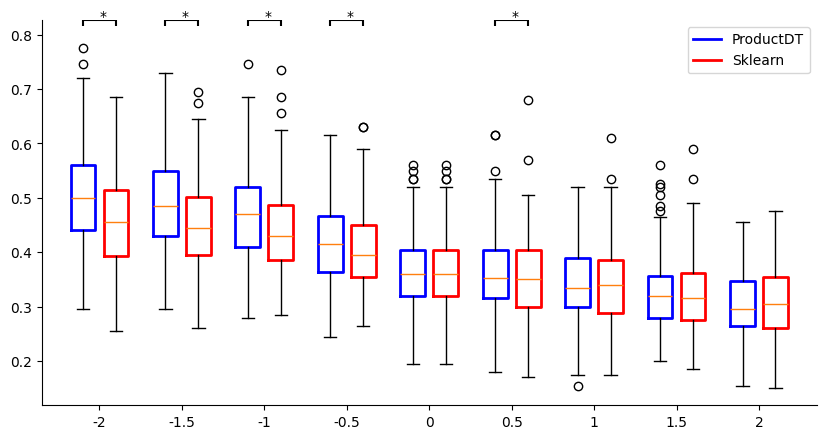

In [167]:
# Let's see the values: barplot with statistical significance annotations

from scipy.stats import ttest_rel

# psdt_means, dt_means, psdt_stds, dt_stds, p_vals = [], [], [], [], []
psdt_scores_by_curvature, dt_scores_by_curvature, p_vals = [], [], []
for K in CURVATURES:
    res_K = results[results["curvature"] == K]
    psdt_scores_by_curvature.append(res_K["psdt_acc"])
    dt_scores_by_curvature.append(res_K["dt_acc"])
    p_vals.append(ttest_rel(res_K["psdt_acc"], res_K["dt_acc"]).pvalue)


plt.figure(figsize=(10, 5))
x_vals = np.arange(len(CURVATURES))
bp1 = plt.boxplot(
    psdt_scores_by_curvature,
    positions=x_vals - 0.2,
    widths=0.3,
    boxprops=dict(color="blue", linewidth=2),
)
bp2 = plt.boxplot(
    dt_scores_by_curvature,
    positions=x_vals + 0.2,
    widths=0.3,
    boxprops=dict(color="red", linewidth=2),
)

# Add asterisks
ymin, ymax = plt.gca().get_ylim()
for x, p_val in zip(x_vals, p_vals):
    if p_val < 0.05:
        plt.text(x, ymax + 0.02, "*", color="black")
        plt.hlines(ymax + 0.02, x - 0.2, x + 0.2, color="black")
        plt.vlines(x - 0.2, ymax + 0.01, ymax + 0.02, color="black")
        plt.vlines(x + 0.2, ymax + 0.01, ymax + 0.02, color="black")

# Fix y-lim and remove top/right spines
plt.ylim(ymin, ymax + 0.02)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Set x-ticks
plt.xticks(x_vals, CURVATURES)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["ProductDT", "Sklearn"])
plt.show()